# Virtual products

Virtual products will enable ODC users to declaratively specify on-the-fly computation to be performed while loading data.

In [1]:
import logging

import yaml

from datacube import Datacube
from datacube.virtual.recipe import create

logging.getLogger("datacube").setLevel(logging.ERROR)

In [2]:
query = {
    'time': ('2014-01-01', '2014-06-01'),
    'lat': (-27.0, -27.1),
    'lon': (127.5, 127.6)
}

Here we define the virtual product by a "recipe" written in `yaml`. It specifies a tree of computations whose leaf nodes are datacube products.

A `collate` node concatenates observations from multiple sensors having the same set of measurements. A `juxtapose` node merges disjoint sets of measurements from different products.

Users can specify any `transform` (that implements the `Transformation` interface defined in the `datacube.virtual` module) to be applied to the loaded data. Here we mask out clouded pixels from our surface reflectance data by first creating a mask by specifying some flags, and then applying this mask to the rest of the measurements.

In [3]:
cloud_free_nbar = create(yaml.load("""
    collate:
      - transform: datacube.virtual.transformations.ApplyMask
        mask_measurement_name: pixelquality
        source:
          transform: datacube.virtual.transformations.MakeMask
          flags:
              blue_saturated: false
              cloud_acca: no_cloud
              cloud_fmask: no_cloud
              cloud_shadow_acca: no_cloud_shadow
              cloud_shadow_fmask: no_cloud_shadow
              contiguous: true
              green_saturated: false
              nir_saturated: false
              red_saturated: false
              swir1_saturated: false
              swir2_saturated: false
          mask_measurement_name: pixelquality
          source:
            juxtapose:
              - product: ls7_nbar_albers
                measurements: ['red', 'green', 'blue']
              - product: ls7_pq_albers
      - transform: datacube.virtual.transformations.ApplyMask
        mask_measurement_name: pixelquality
        source:
          transform: datacube.virtual.transformations.MakeMask
          flags:
              blue_saturated: false
              cloud_acca: no_cloud
              cloud_fmask: no_cloud
              cloud_shadow_acca: no_cloud_shadow
              cloud_shadow_fmask: no_cloud_shadow
              contiguous: true
              green_saturated: false
              nir_saturated: false
              red_saturated: false
              swir1_saturated: false
              swir2_saturated: false
          mask_measurement_name: pixelquality
          source:
            juxtapose:
              - product: ls8_nbar_albers
                measurements: ['red', 'green', 'blue']
              - product: ls8_pq_albers
    """))


In [4]:
dc = Datacube()

In [18]:
nbar_data = cloud_free_nbar.load(dc, **query)

We now plot the loaded data.

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

from datacube.storage.masking import mask_invalid_data

def plot_with_colors(data, fake_saturation=4000):
    rgb = mask_invalid_data(data).to_array(dim='color')
    rgb = rgb.transpose(*(rgb.dims[1:]+rgb.dims[:1]))  # make 'color' the last dimension
    rgb = rgb.where((rgb <= fake_saturation).all(dim='color'))  # mask out pixels where any band is 'saturated'
    rgb /= fake_saturation  # scale to [0, 1] range for imshow
    
    rgb.plot.imshow(x=data.crs.dimensions[1], y=data.crs.dimensions[0],
                    col='time', col_wrap=5, add_colorbar=False)

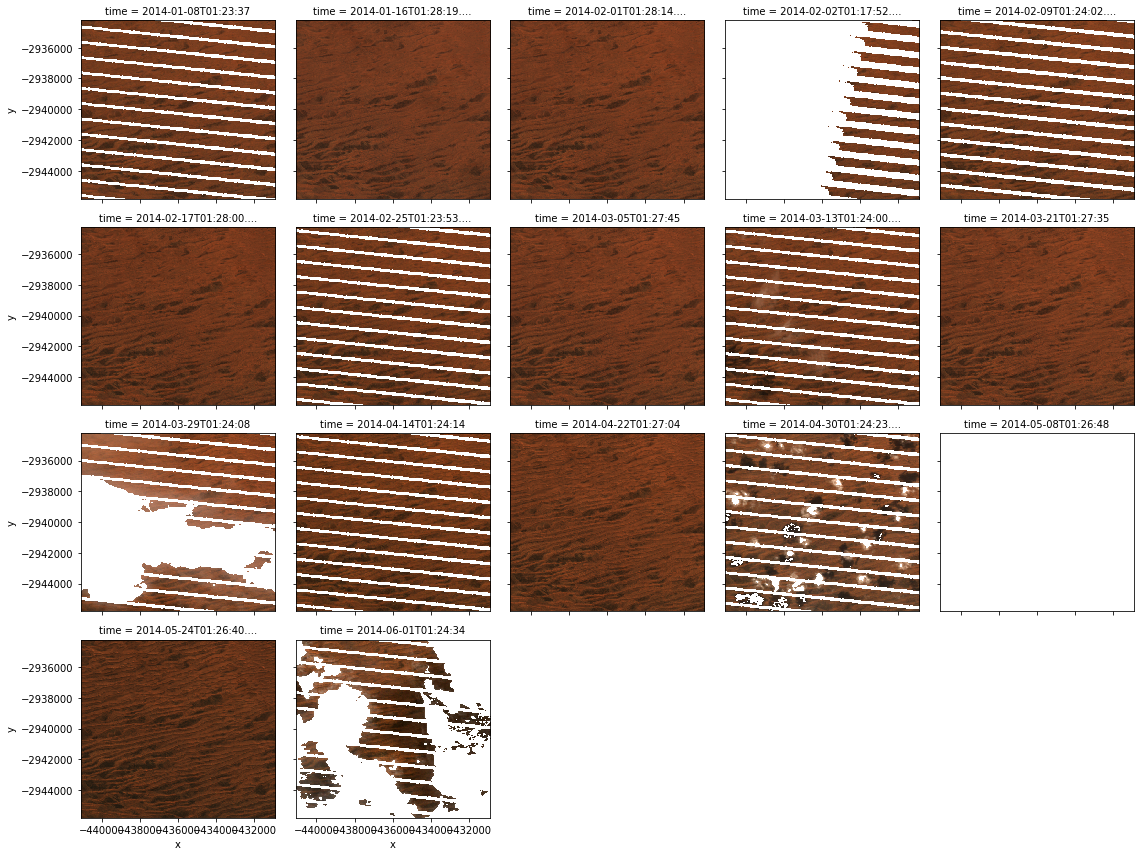

In [19]:
plot_with_colors(nbar_data)

We can see here (cloud-free) Landsat-7 data (with those notorious stripes) interlaced with much more pleasant (cloud-free) Landsat-8 data.

As an example of user-specified transformations, let's calculate the NDVI of Landsat-8 surface reflectance data. This time instead of a `yaml` recipe, we use the combinators directly.

For the on-the-fly transformation, we need to implement not only the `compute` method that operates on the loaded data, but also the corresponding `measurements` method that describes the contents of the resultant `xarray.Dataset` object.

In [15]:
from datacube.virtual import basic_product, transform, Transformation
from datacube.model import Measurement

In [16]:
class NDVI(Transformation):
    def compute(data):
        result = ((data.nir - data.red) / (data.nir + data.red))
        return result.to_dataset(name='NDVI')

    def measurements(input_measurements):
        return {'NDVI': Measurement(name='NDVI', dtype='float64', nodata=float('nan'), units='1')}

In [25]:
ndvi = transform(basic_product(product='ls8_nbar_albers', measurements=['red', 'nir']), NDVI)

In [26]:
ndvi_data = ndvi.load(dc, **query)

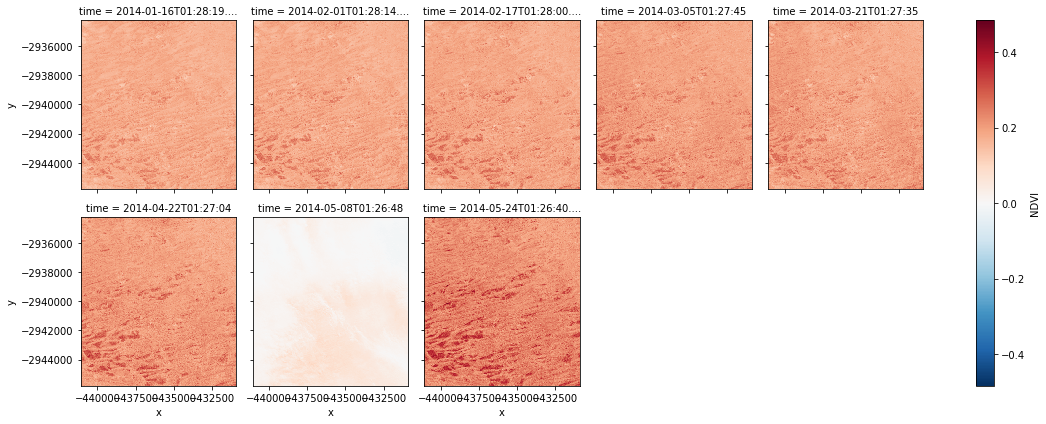

In [37]:
ndvi_data.NDVI.plot(col='time', col_wrap=5)

We can also easily verify that the odd-one-out observation just happened to be very cloudy.

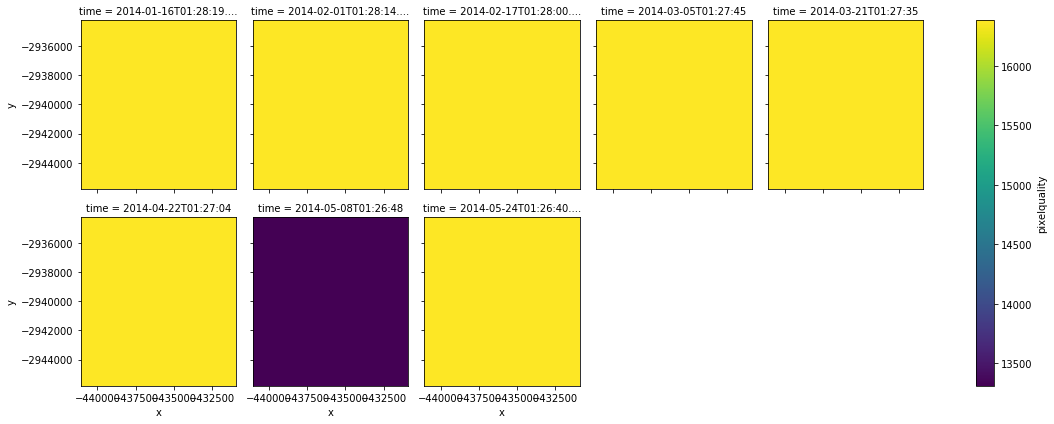

In [42]:
dc.load(product='ls8_pq_albers', **query).pixelquality.plot(col='time', col_wrap=5)